## Link to GitHub repository
https://github.com/linusghanadan/mt_whitney_land_cover

## Purpose
In this analysis, I’ll use a raster dataset from the U.S. Geological Survey (USGS) to extract land cover statistics in a small region surrounding Mount Whitney in California. The numbers contained in the raster represent land cover classification, so I will also have to use an accompanying CSV file from USGS that tells us what classes of land cover correspond to these numbers. I’ll also be creating a simple map showing the area of analysis relative to Mount Whitney. An analysis of this kind has potential use for government agencies seeking to better understand land cover in a region.

## Highlights of analysis
- Exracting pixels per land cover class from raster dataset
- Marging extracted pixels with tabular dataset matching numeric codes to character strings
- Creating horizontal bar plot showing percent area of different land cover classes
- Extracting bounding box of raster dataset
- Creating map that shows area of land cover analysis relative to Mount Whitney with California boundaries as a basemap

## Data
### USGS land cover raster dataset
The primary dataset that we will be working with comes from the 2011 National Terrestrial Ecosystems data, which was collected as part of the USGS Gap Analysis Project (GAP) by the U.S. Forest Service and Department of the Interior. For the purposes of this analysis, the full, nationwide dataset was pre-processed in Microsoft Planetary Computer to only include the area around Mount Whitney. With 30 meter by 30 meter pixel resolution, this raster dataset is a TIF file and contains numbers representing land cover classification.

Citation: U.S. Geological Survey. 2016. “GAP/LANDFIRE National Terrestrial Ecosystems 2011.” https://doi.org/10.5066/F7ZS2TM0.


In [11]:
import os
import xarray as xr
import rioxarray as rioxr

# Import land cover TIF as xarray.DataArray
lulc_fp = os.path.join(os.getcwd(),'..','..','data','2023-12-11-post-data','land_cover.tif')
lulc = rioxr.open_rasterio(lulc_fp)

### USGS land cover tabular dataset
Our second dataset is also from the 2011 National Terrestrial Ecosystems data and helps us make sense of data in the raster dataset. This tabular dataset is a CSV file and has the land cover classification names associated with each code used in the raster dataset. This dataset was accessed from the same online source as the raster dataset.

In [12]:
import pandas as pd

# Import accompanying CSV as pandas.DataFrame
class_names = pd.read_csv('../../data/2023-12-11-post-data/GAP_National_Terrestrial_Ecosystems.csv')

### Shapefile of California geographic boundaries
The final dataset that we will be using is a shapefile of California geographic boundaries, included in the U.S. Census Bureau's 2016 Topologically Integrated Geographic Encoding and Referencing (TIGER) database. We will use this shapefile to plot our basemap when visualizing our area of analysis.

Citation: California Open Data. 2019. “CA State Boundary.” https://data.ca.gov/dataset/ca-geographic-boundaries/resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b

In [13]:
import pandas as pd
import geopandas as gpd

# Import CA shapefile as geopandas.GeoDataFrame
ca = gpd.read_file('https://data.ca.gov/dataset/e212e397-1277-4df3-8c22-40721b095f33/resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b/download/ca-state-boundary.zip')

## Import libraries and functions

In [14]:
# General libraries and functions
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Geospatial libraries and functions
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box
from shapely.geometry import Point

## Raster reduction

In [15]:
# Remove band dimension
lulc = lulc.squeeze()

# Remove coordinates associated to band
lulc = lulc.drop('band')

## Calculate percent area of land cover classes

In [16]:
# Extract pixels per land cover class
codes, counts = np.unique(lulc, return_counts = True)

# Create extracted pixels DataFrame
pix_counts = pd.DataFrame({'code': codes, 'count': counts})

# Merge extracted pixels DataFrame with class names DataFrame
classes = pd.merge(pix_counts, class_names, on='code', how='inner')

# Calculate the percentage of area covered by each class
classes['percentage'] = (classes['count'] / lulc.size) * 100

## Create horizontal bar plot

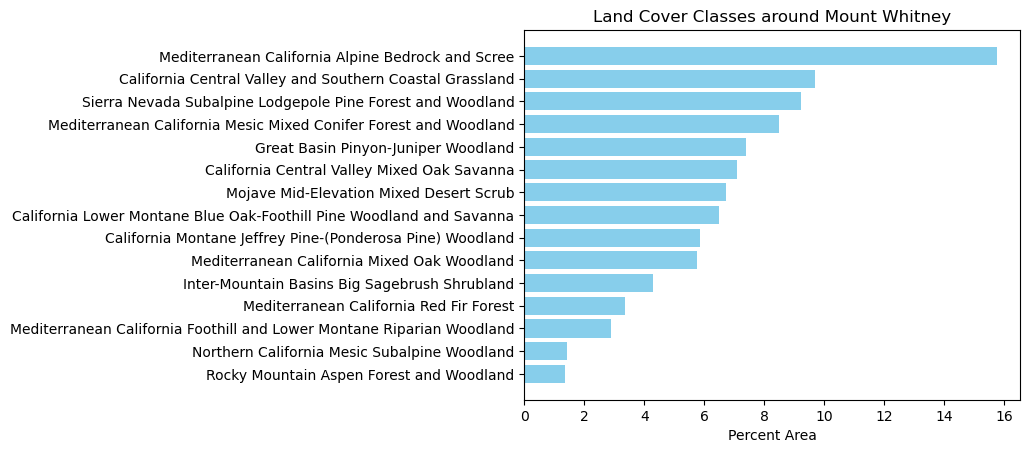

In [17]:
# Filter for classes with more than 1% land cover
filtered_classes = classes[classes['percentage'] > 1]

# Sort classes in decreasing order of percentage
sorted_classes = filtered_classes.sort_values(by='percentage', ascending=True)

# Create a horizontal bar plot with axis label and title
plt.barh(sorted_classes['class_label'], sorted_classes['percentage'], color='skyblue')
plt.xlabel('Percent Area')
plt.title('Land Cover Classes around Mount Whitney')

# Show plot
plt.show()

The horizontal bar plot shows the percent area of different land cover classes in the area around Mount Whitney. Of any one class, "Mediterrabean California Alpine Bedrock and Scree" takes up the most land, constituting just over 15% of the analysis area. "California Central Valley and Southern Coastal Grassland", "Sierra Nevada Subalpine Lodgepole Pine Forest and Woodland", and "Mediterranean California Mesic Mixed Conifer Forest and Woodland" each make up about 8-10% of the area. Seeveral other land cover classifications make up less than 8% of the area.

## Create GeoDataFrames for area of analysis and Mount Whitney

In [18]:
# Extract bounding box of LULC tile
bbox_coords = lulc.rio.bounds()

# Create shapely polygon from bounding box coordinates
bbox_polygon = box(bbox_coords[0], bbox_coords[1], bbox_coords[2], bbox_coords[3])

# Create GeoDataFrame for bounding box of LULC tile
bbox = gpd.GeoDataFrame(geometry=[bbox_polygon], crs=lulc.rio.crs)

# Create GeoDataFrame with a single point for Mount Whitney
mt_whitney = gpd.GeoDataFrame(geometry=[Point(-118.2929, 36.5786)], crs='EPSG:4326')

## Plot map showing area of land cover analysis relative to Mount Whitney

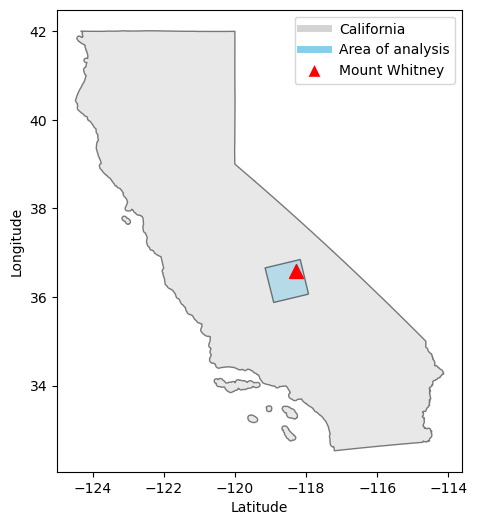

In [19]:
# Change CRS of LULC tile bounding box to EPSG:4326
bbox.to_crs('EPSG:4326', inplace=True)

# Change CRS of CA boundaries to EPSG:4326
ca.to_crs('EPSG:4326', inplace = True)

# Initialize figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot CA basemap, LULC tile bounding box, and Mount Whitney point
ca.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5, label='California, US')
bbox.plot(ax=ax, color='skyblue', edgecolor='black', alpha=0.5, label='Area of analysis')
mt_whitney.plot(ax=ax, marker='^', color='red', markersize=100, label='Mount Whitney')

# Specify legend elements
legend_elements = [plt.Line2D([0], [0], color='lightgray', lw=5, label='California'),
                   plt.Line2D([0], [0], color='skyblue', lw=5, label='Area of analysis'),
                   mlines.Line2D([0], [0], marker='^', color='w', markerfacecolor='red', markersize=10, label='Mount Whitney', linestyle='None')]

# Add legend, title, and labels
ax.legend(handles=legend_elements, loc='upper right')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Show plot
plt.show()

This map shows our area of land cover analysis in relation to Mount Whitney.